# Wildfire Detection

#### Language: Python

#### Libaries: open-cv,scikit-learn, scikit-image, pickle

#### Dataset: https://www.kaggle.com/datasets/anamibnjafar0/flamevision

## 1-Import libaries

In [1]:
import os
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

## 2-Defining Image Classification and Testing Class Objects

In [2]:
class image_classification_SVC:
    def __init__(self, data_path, size=30, test_size=0.25):
        self.data_path = data_path
        self.size = size
        self.test_size = test_size
        self.categories = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.best_model = None

    def show_images(self):
        # Display random images from each category to visualize the dataset.
        cwd = os.getcwd()
        for label_index in range(len(self.categories)):
            plt.figure(figsize=(15, 10))
            input_dir = os.path.join(cwd, self.data_path, self.categories[label_index])
            random_image_path_list = list(np.random.randint(len(os.listdir(input_dir)) - 1, size=5))
            for index, i in enumerate(random_image_path_list):
                image_num = os.listdir(input_dir)[i]
                image_path = os.path.join(input_dir, image_num)
                img = mpimg.imread(image_path)
                plt.subplot(1, 5, index + 1)
                imgplot = plt.imshow(img)
                plt.title(self.categories[label_index])
            plt.show()

    def prepare_data(self,verbose=False):
        # Load and preprocess image data for model training and testing.
        cwd = os.getcwd()
        input_dir = os.path.join(cwd, self.data_path)
        self.categories = os.listdir(input_dir)
        data = []
        labels = []
        for category_idx, category in enumerate(self.categories):
            for file in os.listdir(os.path.join(input_dir, category)):
                img_path = os.path.join(input_dir, category, file)
                img = imread(img_path)
                img = resize(img, (self.size, self.size))
                data.append(img.flatten())
                labels.append(category_idx)
        data = np.asarray(data)
        labels = np.asarray(labels)
        x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=self.test_size, shuffle=True, stratify=labels)
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        if verbose:
            print("Data preprocessing is finished")

    def best_params(self, model, params, counter=2, sample_numbers=9, verbose=False):
        # Hyperparameter tuning for the model using GridSearchCV.
        initial_counter = counter
        grid_search = GridSearchCV(model, params)
        grid_search.fit(self.x_train, self.y_train)
        best_estimator = grid_search.best_estimator_
        print("Current Best C: ", best_estimator.C)
        print("Current Best Gamma: ", best_estimator.gamma)        
        while counter != 0:
            counter -= 1
            new_params = {}
            gamma_list = []
            gamma_list.append(float(grid_search.best_estimator_.gamma))
            new_params["gamma"] = gamma_list
            c_list = list(np.round(np.linspace(float(best_estimator.C) * (1 - 1 / (initial_counter - counter)), float(best_estimator.C) * (1 + 1 / (initial_counter - counter)), sample_numbers), 4))
            new_params["C"] = c_list
            degree_list = [grid_search.best_estimator_.degree]
            new_params["degree"] = degree_list
            kernel_list = [grid_search.best_estimator_.kernel]
            new_params["kernel"] = kernel_list
            if verbose:
                print("Current Grid Search Params: ", new_params)
                print("Current Best C: ", best_estimator.C)
            model = SVC()
            grid_search = GridSearchCV(model, new_params)
            grid_search.fit(self.x_train, self.y_train)
            best_estimator = grid_search.best_estimator_

        counter = initial_counter

        while counter != 0:
            counter -= 1
            new_params = {}
            c_list = []
            c_list.append(float(grid_search.best_estimator_.C))
            new_params["C"] = c_list
            gamma_list = list(np.round(np.linspace(float(best_estimator.gamma) * (1 - 1 / (initial_counter - counter)), float(best_estimator.gamma) * (1 + 1 / (initial_counter - counter)), sample_numbers), 4))
            new_params["gamma"] = gamma_list
            degree_list = [grid_search.best_estimator_.degree]
            new_params["degree"] = degree_list
            kernel_list = [grid_search.best_estimator_.kernel]
            new_params["kernel"] = kernel_list
            if verbose:
                print("Current Grid Search Params: ", new_params)
                print("Current Best Gamma: ", best_estimator.gamma)
            model = SVC()
            grid_search = GridSearchCV(model, new_params)
            grid_search.fit(self.x_train, self.y_train)
            best_estimator = grid_search.best_estimator_
        if verbose:
            print("Best C is:" + str(best_estimator.C) + " Best gamma is:" + str(best_estimator.gamma))
        return best_estimator

    def test_performance(self, model):
        # Evaluate the model's performance on the test data.
        y_prediction = model.predict(self.x_test)
        score = accuracy_score(y_prediction, self.y_test)
        print('{}% of samples were correctly classified'.format(str(score * 100)))
        print("Confusion Matrix:")
        print(confusion_matrix(y_prediction, self.y_test))

In [3]:
class testing_model:
    def __init__(self, model, categories,test_path,size=30):
        self.model = model
        self.categories = categories
        self.data_path = test_path
        self.size = size
        
    def show_predicts(self):
        # Show predictions on random images from each category.
        cwd = os.getcwd()
        for label_index in range(len(self.categories)):
            plt.figure(figsize=(15, 10))
            input_dir = os.path.join(cwd, self.data_path, self.categories[label_index])
            random_image_path_list = list(np.random.randint(len(os.listdir(input_dir)) - 1, size=5))
            for index, i in enumerate(random_image_path_list):
                image_num = os.listdir(input_dir)[i]
                image_path = os.path.join(input_dir, image_num)
                img = imread(image_path)
                img = resize(img, (self.size, self.size))
                data = []
                data.append(img.flatten())
                data = np.asarray(data)
                y_prediction = self.model.predict(data)
                image = mpimg.imread(image_path)
                plt.subplot(1, 5, index + 1)
                imgplot = plt.imshow(image)
                plt.title(self.categories[y_prediction[0]], color="green" if y_prediction == label_index else "red")
            plt.show()

    def process_video_and_create_output(self, video_path, output_video_path, output_directory, frame_rate=30):
        if self.model is None:
            self.model = self.best_model
        if self.categories is None:
            self.categories[::-1]
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        self.save_frames_from_video(video_path, output_directory)
        self.image_predict(output_directory, self.categories)
        self.create_video_from_frames(output_directory, output_video_path, frame_rate)

    def create_video_from_frames(self, input_directory, output_video_path, frame_rate=30):
        # Create a video from a sequence of frames.
        images = [img for img in os.listdir(input_directory) if img.endswith(".jpg")]
        frame = cv2.imread(os.path.join(input_directory, images[0]))
        height, width, layers = frame.shape
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))
        for image in images:
            img_path = os.path.join(input_directory, image)
            frame = cv2.imread(img_path)
            out.write(frame)
        out.release()

    def image_predict(self, input_directory, categories):
        # Perform image classification on a sequence of frames.
        frame_count = 0
        for path in list(os.listdir(input_directory)):
            img_path = os.path.join(input_directory, path)
            data = []
            frame = cv2.imread(os.path.join(input_directory, path))
            imgo = imread(img_path)
            img = resize(imgo, (self.size, self.size))
            data.append(img.flatten())
            data = np.asarray(data)
            y_prediction = self.model.predict(data)
            y_prediction = categories[y_prediction[0]]
            prediction_text = f'Category: {y_prediction}'
            cv2.putText(frame, prediction_text, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            frame_filename = os.path.join(input_directory, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            frame_count += 1

    def save_frames_from_video(self, video_path, output_directory):
        # Extract frames from a video and save them as images.
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_filename = os.path.join(output_directory, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            frame_count += 1

        cap.release()

    def camera_test_and_save(self, categories, window_width=800, window_height=600, save_directory="captured_images"):
        # Capture images from the camera and classify them.
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        cap = cv2.VideoCapture(0)

        cv2.namedWindow('Camera Test', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Camera Test', window_width, window_height)

        while True:
            ret, frameo = cap.read()

            if not ret:
                break
            image_filename = f"current.jpg"
            cv2.imwrite(image_filename, frameo)
            
            data = []
            img_path = os.path.join("current.jpg")
            img = imread(img_path)
            img = resize(img, (self.size, self.size))
            data.append(img.flatten())
            data = np.asarray(data)
            y_prediction = self.model.predict(data)
            y_prediction = categories[y_prediction[0]]
            prediction_text = f'Category: {y_prediction}'
            cv2.putText(frameo, prediction_text, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.imshow('Camera Test', frameo)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q') or key == ord('Q'):
                break

        cap.release()
        cv2.destroyAllWindows()

## 3-Defining saving and loading model functions

In [4]:
def save_model(model, model_filename):
    # Save the trained model to a file using pickle.
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)

def load_model(model_filename):
    # Load a model from a file using pickle.
    with open(model_filename, 'rb') as model_file:
        return pickle.load(model_file)

## 4-Training model

In [5]:
#Initialize the image_classification_SVC class and perform training and testing.
svc = image_classification_SVC(data_path=r'wildfire\data', size=15, test_size=0.25)
svc.prepare_data(verbose=True)
best_model = svc.best_params(SVC(), params={'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1]}, verbose=True, sample_numbers=3)
svc.test_performance(best_model)

Data preprocessing is finished
Current Best C:  10
Current Best Gamma:  0.1
Current Grid Search Params:  {'gamma': [0.1], 'C': [0.0, 10.0, 20.0], 'degree': [3], 'kernel': ['rbf']}
Current Best C:  10


C:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_para

Current Grid Search Params:  {'gamma': [0.1], 'C': [5.0, 10.0, 15.0], 'degree': [3], 'kernel': ['rbf']}
Current Best C:  10.0
Current Grid Search Params:  {'C': [5.0], 'gamma': [0.0, 0.1, 0.2], 'degree': [3], 'kernel': ['rbf']}
Current Best Gamma:  0.1
Current Grid Search Params:  {'C': [5.0], 'gamma': [0.05, 0.1, 0.15], 'degree': [3], 'kernel': ['rbf']}
Current Best Gamma:  0.1
Best C is:5.0 Best gamma is:0.1
99.89572471324296% of samples were correctly classified
Confusion Matrix:
[[1073    0]
 [   2  843]]


## 5-Saving model

In [6]:
# Save the trained model to a file
save_model(best_model, 'trained_model.pkl')

## 6-Testing model with random validation images

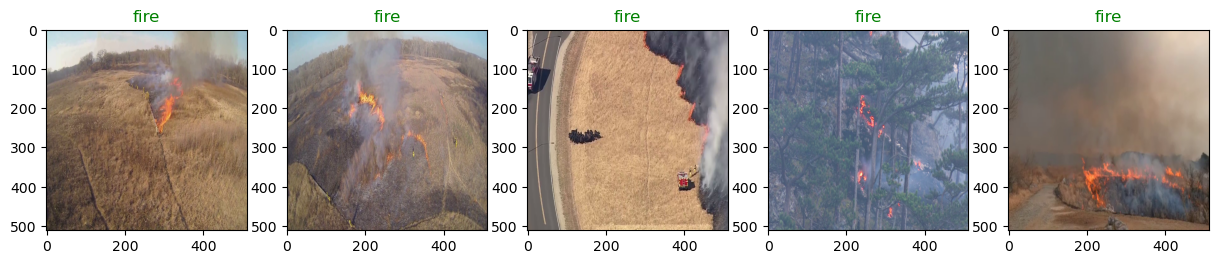

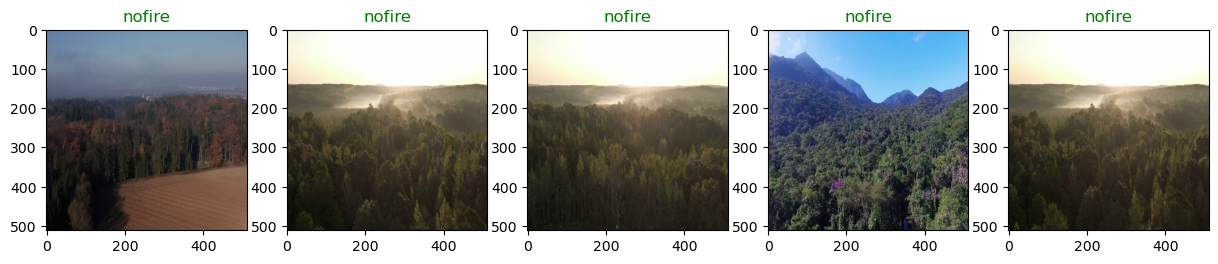

In [7]:
# Initialize the testing_model class with the loaded model and categories.
test_model = testing_model(load_model('trained_model.pkl'), ['fire', 'nofire'], test_path=r"wildfire\validation",size=15)
test_model.show_predicts()

## 7-Testing model with input videos

In [8]:
test_model.process_video_and_create_output('input_video_1.mp4', 'output_video_1.mp4', 'video_1_output_frames/')

In [9]:
test_model.process_video_and_create_output('input_video_2.mp4', 'output_video_2.mp4', 'video_2_output_frames/')

## 8-Live test of Model

In [10]:
# Use the camera and save images for classification.
test_model.camera_test_and_save(categories=['fire', 'nofire'])